In [ ]:
import os
import sys
import json
import random
from datetime import datetime
from tqdm import tqdm_notebook as tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
from nltk.tokenize import TweetTokenizer
import torchtext.data
from torchvision.datasets import coco
from torch.utils.data import DataLoader

from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt

#import pretrainedmodels
#from pretrainedmodels.utils import LoadImage, TransformImage

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

### Paths

In [ ]:
TRAIN_IMAGE_PATH = 'data/train2017/'
TRAIN_CAPTION_PATH = 'data/annotations/captions_train2017.json'

In [ ]:
VAL_IMAGE_PATH = 'data/val2017/'
VAL_CAPTION_PATH = 'data/annotations/captions_val2017.json'

In [ ]:
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

### Image Transforms

In [ ]:
transform_img = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
import re
import sys
import unicodedata

HALF = ' '
CAP = '\ue302'

def detokenize(l):
#     text = ' '.join(l).replace(CAP + HALF, HALF + CAP)
#     text = re.sub(HALF + '+', lambda s: ' ' * (len(s.group(0)) // 2), text)
#     return re.sub(CAP + '.', lambda s: s.group(0)[-1].upper(), text, flags=re.S)
    return ' '.join(l)

class CustomReversibleField(torchtext.data.ReversibleField):
    def reverse(self, batch):
        if self.use_revtok:
            try:
                import revtok
            except ImportError:
                print("Please install revtok.")
                raise
        if not self.batch_first:
            batch = batch.t()
        with torch.cuda.device_of(batch):
            batch = batch.tolist()
        batch = [[self.vocab.itos[ind] for ind in ex] for ex in batch]  # denumericalize

        def trim(s, t):
            sentence = []
            for w in s:
                if w == t:
                    break
                sentence.append(w)
            return sentence

        batch = [trim(ex, self.eos_token) for ex in batch]  # trim past frst eos

        def filter_special(tok):
            return tok not in (self.init_token, self.pad_token)

        batch = [filter(filter_special, ex) for ex in batch]
        if self.use_revtok:
            return [detokenize(ex) for ex in batch]
        return [''.join(ex) for ex in batch]

In [ ]:
tokenizer = TweetTokenizer()
def tokenize(text):
    return tokenizer.tokenize(text.lower())

TEXT = CustomReversibleField(sequential=True, tokenize=tokenize, lower=True, init_token='<start>', eos_token='<end>', unk_token='<unk>', pad_token='<pad>')
CAPTIONS = torchtext.data.NestedField(TEXT)

In [9]:
class CocoOnlyCaptionsExamples(coco.CocoCaptions):
    """Датасет для подгрузки описаний изображений из coco"""
    
    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        target = [ann['caption'] for ann in anns]
        
        #return target
        return torchtext.data.Example.fromlist(
            [target],
            fields=[
                ('captions', CAPTIONS)
            ]
        )
    
# Считаем все аннотации
coco_train_captions = CocoOnlyCaptionsExamples(
    TRAIN_IMAGE_PATH,
    TRAIN_CAPTION_PATH
)

# Построим словарь с аннотациями, ограничим частоту встречаемости слов снизу
CAPTIONS.build_vocab(
    torchtext.data.Dataset(coco_train_captions, fields=[('captions', CAPTIONS)]),
    min_freq=5
)

loading annotations into memory...
Done (t=0.87s)
creating index...
index created!


In [10]:
len(TEXT.vocab.stoi)

10409

In [11]:
TEXT.process([['sun', 'train'], ['beautiful', 'woman']])

tensor([[  2, 508,  45,   3],
        [  2, 522,  25,   3]])

In [12]:
IMAGE = torchtext.data.Field(use_vocab=False, sequential=False)

In [13]:
class CocoExamples(coco.CocoCaptions):
    """Датасет для подгрузки изображений c описаниями из coco"""
    
    def __getitem__(self, index):
        image, captions = super().__getitem__(index)
        
        return torchtext.data.Example.fromlist(
            [image, captions],
            fields=[
                ('image', IMAGE),
                ('captions', CAPTIONS)
            ]
        )
    
coco_train = CocoExamples(
    TRAIN_IMAGE_PATH,
    TRAIN_CAPTION_PATH,
    transform = transform_img
)

coco_val = CocoExamples(
    VAL_IMAGE_PATH,
    VAL_CAPTION_PATH,
    transform = transform_img
)

loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [14]:
from random import choice

def collate_fn(samples):
    # Объединяем изображения
    images = torch.cat(tuple(map(lambda s: s.image.unsqueeze(0), samples)))
    
    # Выбираем случаное описание изображения
    captions = list(map(lambda s: s.captions, samples))
    captions = list(map(choice, captions))

    return images, TEXT.process(captions)

In [15]:
train_dataloader = DataLoader(coco_train, batch_size=16, collate_fn=collate_fn, shuffle=True, drop_last=True)
val_dataloader = DataLoader(coco_val, batch_size=16, collate_fn=collate_fn, shuffle=True)

In [16]:
_images, _captions = next(iter(train_dataloader))

# NN

In [17]:
from torchvision.models import densenet121

modules = densenet121(pretrained=True)
modules = list(modules.children())[:-1]
image_warper = nn.Sequential(*modules)

image_warper(_images).size()

torch.Size([16, 1024, 7, 7])

In [18]:
pool = nn.AdaptiveAvgPool2d(1)

In [19]:
pool(image_warper(_images)).size()

torch.Size([16, 1024, 1, 1])

In [20]:
class Encoder(nn.Module):
    def __init__(self, encoded_image_size=1):
        super().__init__()
        
        self.encoded_image_size = encoded_image_size
        
        modules = densenet121(pretrained=True)
        modules = list(modules.children())[:-1]
        self.image_warper = nn.Sequential(*modules)
        self.apool = nn.AdaptiveAvgPool2d((self.encoded_image_size, self.encoded_image_size))

        
    def forward(self, images):
        out = self.image_warper(images)
        out = self.apool(out)
        out = out.permute(0, 2, 3, 1)
        
        batch_size, enc_image_size, _, encoder_dim = out.shape
        out = out.view(batch_size, -1, encoder_dim)
        
        return out
    
    
ie = Encoder()
_images_encoded = ie(_images)
_images_encoded.shape

torch.Size([16, 1, 1024])

In [22]:
class Decoder(nn.Module):
    def __init__(self, enc_dim=1024, emb_dim=150, dec_dim=128, vocab_size=len(TEXT.vocab), pad_idx=TEXT.vocab.stoi[TEXT.pad_token], dropout=0.5):
        super().__init__()
        
        self.enc_dim = enc_dim
        self.emb_dim = emb_dim
        self.dec_dim = dec_dim
        self.vocab_size = vocab_size
        self.pad_idx = pad_idx
        self.dropout = dropout
        
        self.embedding = nn.Embedding(self.vocab_size, self.emb_dim)
        self.decoder = nn.LSTM(self.emb_dim, self.emb_dim, batch_first = True)
        self.init_h = nn.Linear(self.enc_dim, self.emb_dim)
        self.init_c = nn.Linear(self.enc_dim, self.emb_dim)
        self.out = nn.Linear(self.emb_dim, self.vocab_size)

        
        self.init_weights()
        
    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.out.bias.data.fill_(0)
        self.out.weight.data.uniform_(-0.1, 0.1)
        
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c
    
    def forward(self, encoder_out, captions_ix):
        # encoder_out - [batch_size, num_pixels, encoder_dim]
        # captions - [batch_size, max_caption_len]
        
        batch_size, num_pixels, enc_dim = encoder_out.shape
        
        # Восстанавливаем длины последовательностей
        caption_lengths = (captions_ix != self.pad_idx).sum(axis=1)
        
        # Осуществляем embedding
        embeddings = self.embedding(captions_ix)
        # Начальное состояние
        # h - [batch_size, dec_dim]
        # c - [batch_size, dec_dim]
        h, c = self.init_hidden_state(encoder_out)
        h = h.unsqueeze(0)
        c = c.unsqueeze(0)
        output, _ = self.decoder(embeddings, (h, c))
        
        #print('c:',c.shape)
        # Сколько реальных символов необходимо сгенерировать
        #decode_lengths = (caption_lengths - 1).tolist()
        decode_lengths = caption_lengths.tolist()
        
        predictions = self.out(output.squeeze(0))
        
         
        return predictions, captions_ix, decode_lengths

        
idec = Decoder()
predictions, captions_ix, decode_lengths = idec(_images_encoded, _captions)
print('predictions:', predictions.shape)
print('captions_ix:', captions_ix.shape)
# print(sort_ind.shape)

predictions: torch.Size([16, 18, 10409])
captions_ix: torch.Size([16, 18])


In [23]:
class Caption(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, image_vectors, captions_ix):
        encoded_images = self.encoder(image_vectors)
        return self.decoder(encoded_images, captions_ix)

In [24]:
ienc = Encoder().to(device)
idec = Decoder().to(device)
network = Caption(ienc, idec).to(device)

In [25]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # Восстанавливаем длины последовательностей
    caption_lengths = (captions_ix != TEXT.vocab.stoi[TEXT.pad_token]).sum(axis=1)
    
    # Сортируем входные данные по длинам последовательностей
    caption_lengths, sort_ind = caption_lengths.sort(dim=0, descending=True)
    image_vectors = image_vectors[sort_ind]
    captions_ix = captions_ix[sort_ind]
        
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    #predictions, captions_ix, decode_lengths, alphas, sort_ind = network.forward(image_vectors, captions_ix_inp)
    predictions, captions_ix, decode_lengths = network.forward(image_vectors, captions_ix_inp)
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    loss = F.cross_entropy(
        predictions.view(-1, predictions.size(2)),
        captions_ix_next.view(-1),
        ignore_index=TEXT.vocab.stoi[TEXT.pad_token]
    )
    
    
    return loss

In [26]:
from torch import optim
opt = optim.Adam(network.parameters(), lr=1e-3)

In [27]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
    return [x for x in mystr if x not in tokens_to_remove]


def get_text(x, TRG_vocab):
    text = [TRG_vocab.itos[token] for token in x]
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = remove_tech_tokens(text)
    if len(text) < 1:
        text = []
    return text

In [32]:
batch_size = 16  
n_epochs = 50 
n_batches_per_epoch = 500  
n_validation_batches = 20  

In [33]:
train_dataloader = DataLoader(coco_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, drop_last=True)
val_dataloader = DataLoader(coco_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

In [34]:
best_bleu = -float('inf')

In [35]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm.notebook import tqdm_notebook as tqdm


for epoch in range(n_epochs):
    # Часть тренировки
    
    train_loss = 0
    network.train(True)
    
    for i, batch in tqdm(zip(range(n_batches_per_epoch), train_dataloader)):
        images, captions = batch
        
        # Переносим на устройство
        images, captions = images.to(device), captions.to(device)
        
        # Считаем лосс
        loss_t = compute_loss(network, images, captions)
        
        network.zero_grad()
        loss_t.backward()
        opt.step()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    
    # Часть валидации
    val_loss = 0
    network.train(False)
    
    original_text = []
    generated_text = []
    
    for _, batch in zip(range(n_validation_batches), val_dataloader):
        images, captions = batch
        
        # Переносим на устройство
        images, captions = images.to(device), captions.to(device)
        
        # Считаем лосс
        with torch.no_grad():
            loss_t = compute_loss(network, images, captions)
            val_loss += loss_t.item()
            
            predictions, captions_ix, decode_lengths = network.forward(images, captions)
            output_bleu = predictions.argmax(dim=-1)

            original_text.extend(([get_text(x, TEXT.vocab) for x in captions_ix.cpu().numpy()]))
            generated_text.extend([get_text(x, TEXT.vocab) for x in output_bleu.cpu().numpy()])
            
    val_loss /= n_validation_batches
    
    val_bleu = corpus_bleu([[text] for text in original_text], generated_text) * 100
    
    if val_bleu >= best_bleu:
        best_bleu = val_bleu
        torch.save(network.state_dict(), 'resnet_lstm_attn_bleu.pth')
    
    print('\nEpoch: {}, train loss: {}, val loss: {}, val bleu: {}'.format(epoch, train_loss, val_loss, val_bleu))



Epoch: 0, train loss: 3.650457618713379, val loss: 3.6443176746368406, val bleu: 3.0641216004178995




Epoch: 1, train loss: 3.519072397708893, val loss: 3.4759472608566284, val bleu: 3.1950466808263385




Epoch: 2, train loss: 3.4700806379318236, val loss: 3.4810732126235964, val bleu: 3.9438421513041604




Epoch: 3, train loss: 3.4163098726272585, val loss: 3.3160884261131285, val bleu: 3.9316798830512263




Epoch: 4, train loss: 3.3493400964736937, val loss: 3.3540759563446043, val bleu: 4.669595955974453




Epoch: 5, train loss: 3.277053288459778, val loss: 3.3600840091705324, val bleu: 4.55026424851937




Epoch: 6, train loss: 3.234998748779297, val loss: 3.232840049266815, val bleu: 4.561712720540351




Epoch: 7, train loss: 3.203563431739807, val loss: 3.2653038144111632, val bleu: 4.125335875859359




Epoch: 8, train loss: 3.1755280900001526, val loss: 3.088212454319, val bleu: 4.8914858016564455




Epoch: 9, train loss: 3.1229618587493895, val loss: 3.0523236870765684, val bleu: 5.709338260218002




Epoch: 10, train loss: 3.110157238006592, val loss: 3.040434169769287, val bleu: 5.704598244195431




Epoch: 11, train loss: 3.096097990512848, val loss: 2.9916664600372314, val bleu: 5.930720589161942




Epoch: 12, train loss: 3.0723933773040772, val loss: 3.0685049653053285, val bleu: 5.655442809619219




Epoch: 13, train loss: 3.0621110067367554, val loss: 3.031180274486542, val bleu: 5.6819355923974895




Epoch: 14, train loss: 3.0426119766235353, val loss: 3.075961780548096, val bleu: 5.1132339330445244




Epoch: 15, train loss: 3.025269420623779, val loss: 3.0528078436851502, val bleu: 6.125479782745995




Epoch: 16, train loss: 2.984819682598114, val loss: 2.945209801197052, val bleu: 5.924701504458514




Epoch: 17, train loss: 2.968204052448273, val loss: 2.9971163749694822, val bleu: 5.717403943248243




Epoch: 18, train loss: 2.9730234150886536, val loss: 2.9744951128959656, val bleu: 6.558744185704099




Epoch: 19, train loss: 2.9491330590248106, val loss: 2.896651256084442, val bleu: 6.404265728944866




Epoch: 20, train loss: 2.9322027678489686, val loss: 2.9643219351768493, val bleu: 5.9743981881019845




Epoch: 21, train loss: 2.920953622817993, val loss: 2.8964327812194823, val bleu: 7.805554274927985




Epoch: 22, train loss: 2.9111580991744996, val loss: 2.923935258388519, val bleu: 7.21810295848331




Epoch: 23, train loss: 2.8983068714141846, val loss: 3.041846585273743, val bleu: 5.7382062355912815




Epoch: 24, train loss: 2.86906272315979, val loss: 2.7933084845542906, val bleu: 7.4169204733901735




Epoch: 25, train loss: 2.8735537509918214, val loss: 2.96236013174057, val bleu: 6.035527090353536




Epoch: 26, train loss: 2.8737096090316774, val loss: 2.9560789346694945, val bleu: 6.568992643564147




Epoch: 27, train loss: 2.837676010131836, val loss: 2.839517521858215, val bleu: 6.989150290712856




Epoch: 28, train loss: 2.8623728976249696, val loss: 2.863622856140137, val bleu: 6.923878233893624




Epoch: 29, train loss: 2.8440194582939147, val loss: 2.8849815726280212, val bleu: 6.753951432344326




Epoch: 30, train loss: 2.8316090602874757, val loss: 2.8415827989578246, val bleu: 6.658859643827795




Epoch: 31, train loss: 2.8285160636901856, val loss: 2.9120496034622194, val bleu: 6.718335779134643




Epoch: 32, train loss: 2.8159510111808777, val loss: 2.8787769436836244, val bleu: 7.281601489181351




Epoch: 33, train loss: 2.8124615330696106, val loss: 2.9512532114982606, val bleu: 6.451635732879046




Epoch: 34, train loss: 2.7917485427856445, val loss: 2.723082756996155, val bleu: 7.802442437228082




Epoch: 35, train loss: 2.7849026951789857, val loss: 2.855863797664642, val bleu: 6.327916506831975




Epoch: 36, train loss: 2.7799389333724975, val loss: 2.816521918773651, val bleu: 7.0688945393608265




Epoch: 37, train loss: 2.755224970817566, val loss: 2.729927825927734, val bleu: 7.914711610474042




Epoch: 38, train loss: 2.775790853500366, val loss: 2.846641147136688, val bleu: 6.149025341038743




Epoch: 39, train loss: 2.7548925671577456, val loss: 2.8256020069122316, val bleu: 7.714120003275278




Epoch: 40, train loss: 2.7567606897354127, val loss: 2.7624190211296082, val bleu: 7.462625522034216




Epoch: 41, train loss: 2.7126931085586548, val loss: 2.692241883277893, val bleu: 8.257375087128631




Epoch: 42, train loss: 2.738518560409546, val loss: 2.756289231777191, val bleu: 7.255388184564773




Epoch: 43, train loss: 2.7145151793956757, val loss: 2.7874503254890444, val bleu: 7.858064799754643




Epoch: 44, train loss: 2.735251901626587, val loss: 2.7920414805412292, val bleu: 7.436646303429099




Epoch: 45, train loss: 2.7181119000911713, val loss: 2.757233214378357, val bleu: 6.7777931733392585




Epoch: 46, train loss: 2.69717716550827, val loss: 2.703422021865845, val bleu: 7.702694673914379




Epoch: 47, train loss: 2.7261314520835875, val loss: 2.766719472408295, val bleu: 7.470049916966016




Epoch: 48, train loss: 2.715032614469528, val loss: 2.645396053791046, val bleu: 8.42395755032291




Epoch: 49, train loss: 2.6966444220542907, val loss: 2.733553409576416, val bleu: 7.470120174470625


torch.Size([1, 10409])
torch.Size([2, 10409])
torch.Size([3, 10409])
torch.Size([4, 10409])
torch.Size([5, 10409])
torch.Size([6, 10409])
torch.Size([7, 10409])
torch.Size([8, 10409])
torch.Size([9, 10409])
torch.Size([10, 10409])
torch.Size([11, 10409])
['<start>', 'a', 'man', 'is', 'riding', 'a', 'wave', 'on', 'a', 'surfboard', '.', '<end>']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


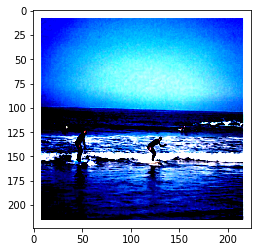

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

def generate_caption(image, caption_prefix=(TEXT.init_token,), t=1, sample=True, max_len=100):
    with torch.no_grad():
        image = image.to(device)
        caption_prefix = list(caption_prefix)
        
        for _ in range(max_len):
            prefix_ix = TEXT.process([caption_prefix])[:, 1:-1].to(device)
            next_word_logits, _, _ = network.forward(image, prefix_ix)
            print(next_word_logits.shape)
            next_word_logits = next_word_logits.unsqueeze(0)[0, -1, :]
            next_word_probs = F.softmax(next_word_logits, dim=-1).cpu().data.numpy()
            
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature
            
            if sample:
                next_word = TEXT.vocab.itos[np.random.choice(range(len(TEXT.vocab.itos)), p=next_word_probs)]
            else:
                next_word = TEXT.vocab.itos[np.argmax(next_word_probs)]
                
            caption_prefix.append(next_word)
            
            if next_word == TEXT.eos_token:
                break
            
        print(caption_prefix)
## Good example)   
generate_caption(_images[[1]], sample=False)
plt.imshow(_images[[1]].squeeze(0).permute([1,2,0]))
plt.show()

torch.Size([1, 10409])
torch.Size([2, 10409])
torch.Size([3, 10409])
torch.Size([4, 10409])
torch.Size([5, 10409])
torch.Size([6, 10409])
torch.Size([7, 10409])
torch.Size([8, 10409])
torch.Size([9, 10409])
torch.Size([10, 10409])
torch.Size([11, 10409])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([12, 10409])
torch.Size([13, 10409])
['<start>', 'a', 'group', 'of', 'people', 'standing', 'in', 'a', 'field', 'with', 'a', 'kite', '.', '<end>']


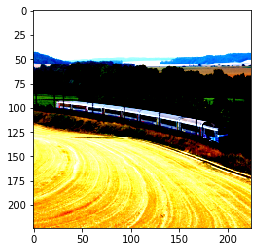

In [54]:
#shit
generate_caption(_images[[12]], sample=False)
plt.imshow(_images[[12]].squeeze(0).permute([1,2,0]))
plt.show()

torch.Size([1, 10409])
torch.Size([2, 10409])
torch.Size([3, 10409])
torch.Size([4, 10409])
torch.Size([5, 10409])
torch.Size([6, 10409])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([7, 10409])
torch.Size([8, 10409])
torch.Size([9, 10409])
torch.Size([10, 10409])
['<start>', 'a', 'baseball', 'player', 'is', 'swinging', 'at', 'a', 'baseball', '.', '<end>']


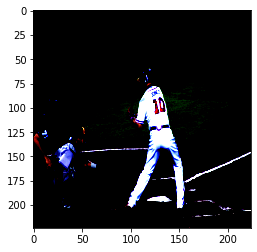

In [55]:
# something about baseball model caught
generate_caption(_images[[7]], sample=False)
plt.imshow(_images[[7]].squeeze(0).permute([1,2,0]))
plt.show()